In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
from hurst import compute_Hc
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [37]:
print("########################## WARNING: USED ffill WITHOUT REVIEWING DATA NOT READY FOR PROD ######################################")

########################## WARNING: USED ffill WITHOUT REVIEWING DATA NOT READY FOR PROD ######################################


In [38]:
ftse_all_share_data = yf.download('^FTAI', start='2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [39]:
ftse_all_share_data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1,inplace=True)
ftse_all_share_data.index = pd.to_datetime(ftse_all_share_data.index)

In [40]:
ftse_all_share_weekly_close = ftse_all_share_data.asfreq('w', method='ffill')

In [41]:
#ftse_all_share_weekly_close.loc['2023-06-04'] = 7607.28 - Yahoo doesn't update 
#until way after Monday open. This cell is used to update the price manually.

In [42]:
ftse_all_share_weekly_close.index = pd.to_datetime(ftse_all_share_weekly_close.index)

In [43]:
ftse_all_share_weekly_close['Previous 2 weeks returns'] = ftse_all_share_weekly_close.pct_change(2)

In [44]:
ftse_all_share_weekly_close['Next Week Returns'] = ftse_all_share_weekly_close['Adj Close'].pct_change(1).shift(-1)

In [45]:
ftse_all_share_weekly_close = ftse_all_share_weekly_close.iloc[2:]

In [46]:
ftse_all_share_weekly_close['positions'] = np.where(ftse_all_share_weekly_close['Previous 2 weeks returns'] > 0, 1, -1)

In [47]:
ftse_all_share_weekly_close['strategy_returns'] = ftse_all_share_weekly_close['positions'] * ftse_all_share_weekly_close['Next Week Returns']

In [48]:
ftse_all_share_weekly_close['cumulative strategy returns'] = (ftse_all_share_weekly_close['strategy_returns'] + 1).cumprod()

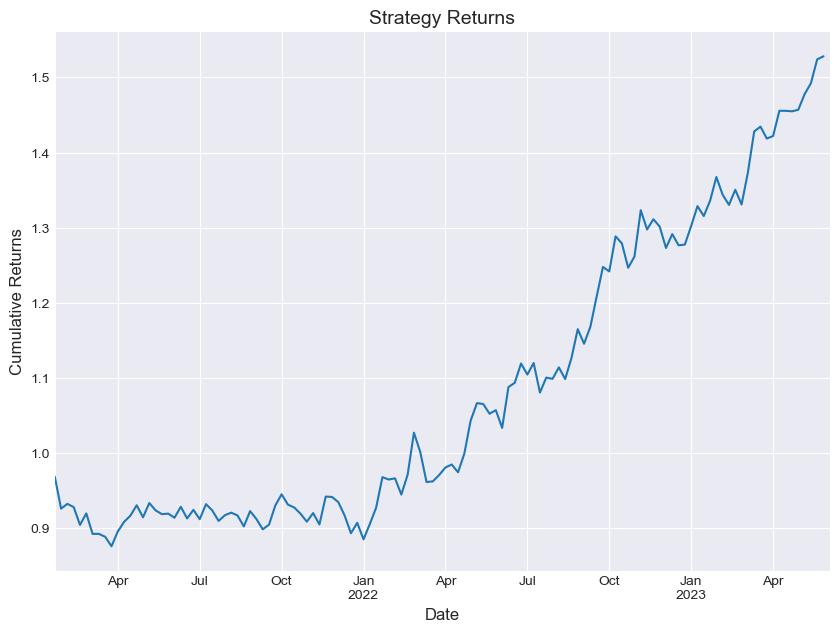

In [49]:
ftse_all_share_weekly_close['cumulative strategy returns'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

In [50]:
#################################### Signals ######################################################

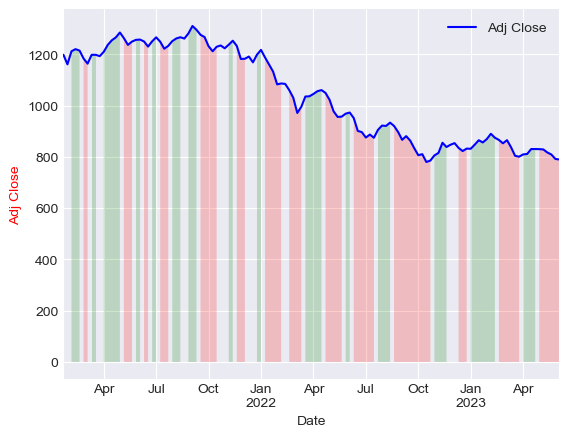

In [51]:
def plot_signal(portfolio):
    ftse_all_share_weekly_close['Adj Close'].plot(color='blue')    
    plt.fill_between(ftse_all_share_weekly_close.index, ftse_all_share_weekly_close['Adj Close'], where=(ftse_all_share_weekly_close.positions==1), facecolor='g', alpha=0.2)
    plt.fill_between(ftse_all_share_weekly_close.index, ftse_all_share_weekly_close['Adj Close'], where=(ftse_all_share_weekly_close.positions==-1), facecolor='r', alpha=0.2)
    plt.legend()    
    plt.ylabel('Adj Close',color='r')
    plt.show()
plot_signal(ftse_all_share_weekly_close)

In [52]:
with pd.option_context('display.max_rows', None, 'display.max_rows', None):
    print(ftse_all_share_weekly_close)

              Adj Close  Previous 2 weeks returns  Next Week Returns  \
Date                                                                   
2021-01-24  1198.089966                  0.015537          -0.031233   
2021-01-31  1160.670044                 -0.010613           0.043863   
2021-02-07  1211.579956                  0.011260           0.006826   
2021-02-14  1219.849976                  0.050988          -0.004648   
2021-02-21  1214.180054                  0.002146          -0.025474   
2021-02-28  1183.250000                 -0.030004          -0.016894   
2021-03-07  1163.260010                 -0.041938           0.029624   
2021-03-14  1197.719971                  0.012229           0.000000   
2021-03-21  1197.719971                  0.029624          -0.004358   
2021-03-28  1192.500000                 -0.004358           0.014172   
2021-04-04  1209.400024                  0.009752           0.022408   
2021-04-11  1236.500000                  0.036897           0.01

In [53]:
#################################### Max Drawdown ##############################################################

The maximum drawdown is -12.38


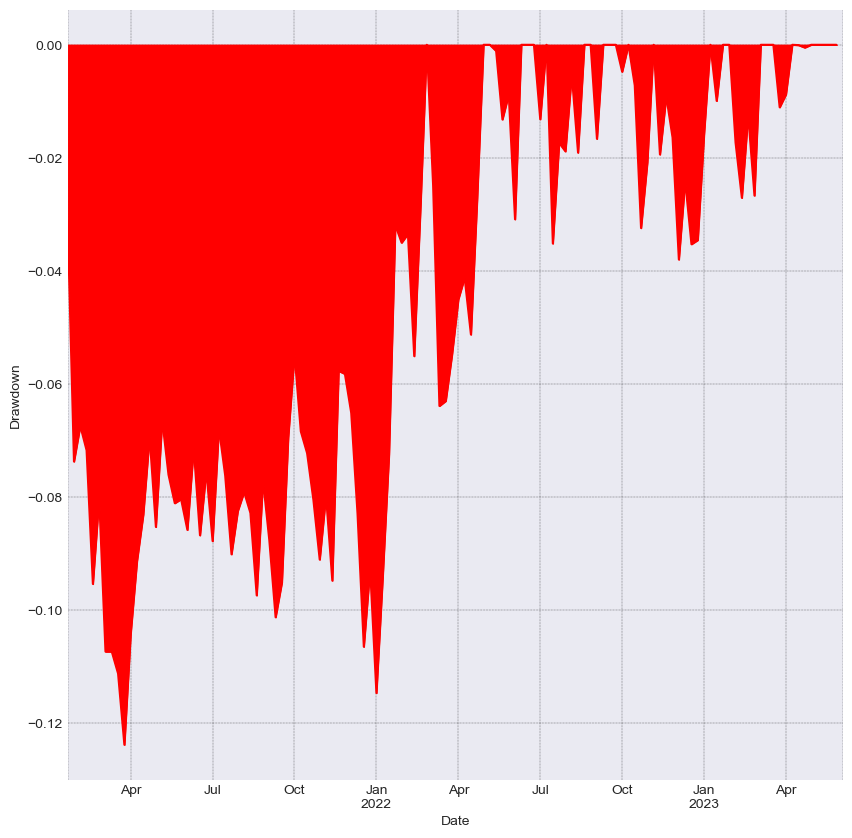

In [54]:
running_max = np.maximum.accumulate(ftse_all_share_weekly_close['cumulative strategy returns'].dropna())
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = (ftse_all_share_weekly_close['cumulative strategy returns'])/running_max - 1
max_dd = drawdown.min()*100
print('The maximum drawdown is %.2f' % max_dd)
# Plot the drawdowns
drawdown.plot(color='r',figsize=(10,10))
plt.ylabel('Drawdown')
plt.fill_between(drawdown.index, drawdown, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
plt.show()


In [56]:
#################################### Buy and Hold FTAI ######################################################

In [57]:
Buy_Hold_Returns = ftse_all_share_weekly_close['Adj Close']
Buy_Hold_Returns = Buy_Hold_Returns.pct_change()
Buy_Hold_Cum_Returns = (Buy_Hold_Returns+1).cumprod()

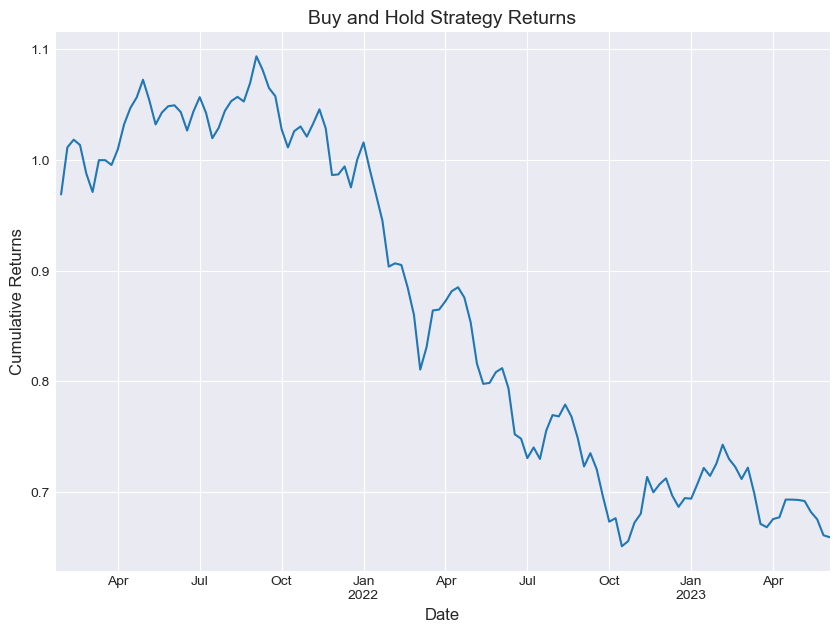

In [58]:
Buy_Hold_Cum_Returns.plot(figsize=(10, 7))

# Set title and labels for the plot
plt.title('Buy and Hold Strategy Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.show()

In [59]:
#################################### Hurst exponent ######################################################

In [60]:
'The Hurst exponent is %.2f' % compute_Hc(ftse_all_share_weekly_close['Adj Close'], kind='price')[0]

'The Hurst exponent is 0.82'

In [61]:
###################### Long returns #################################
ftse_all_share_weekly_close['long_cum_returns'] = np.where(ftse_all_share_weekly_close['positions'] == 1, ftse_all_share_weekly_close['positions'] * ftse_all_share_weekly_close['Next Week Returns'], 0)
ftse_all_share_weekly_close['long_cum_returns'] = (ftse_all_share_weekly_close['long_cum_returns'] + 1).cumprod()

In [62]:
##################### Shorts returns ##################################

In [63]:
ftse_all_share_weekly_close['short_cum_returns'] = np.where(ftse_all_share_weekly_close['positions'] == -1, ftse_all_share_weekly_close['positions'] * ftse_all_share_weekly_close['Next Week Returns'], 0)
ftse_all_share_weekly_close['short_cum_returns'] = (ftse_all_share_weekly_close['short_cum_returns'] + 1).cumprod()

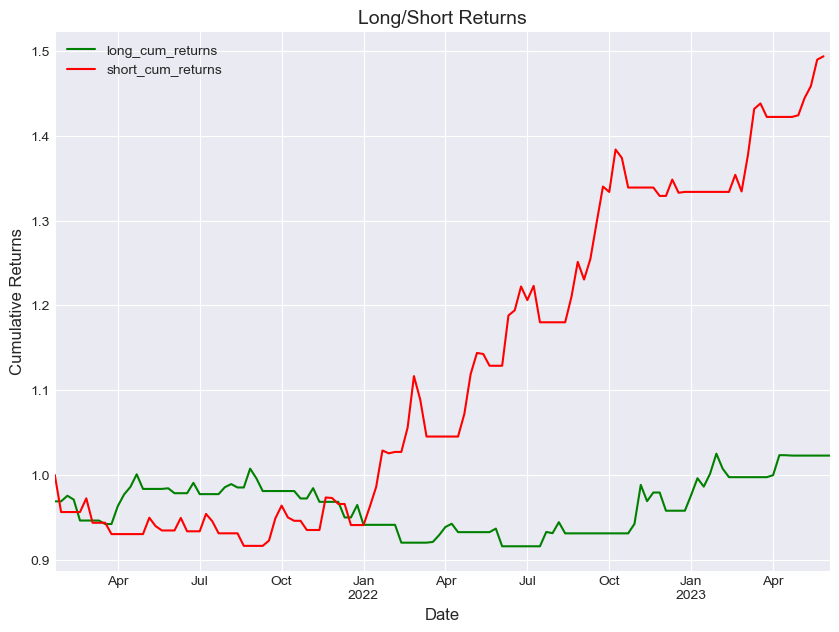

In [64]:
ftse_all_share_weekly_close['long_cum_returns'].plot(figsize=(10, 7), color='g')
ftse_all_share_weekly_close['short_cum_returns'].plot(figsize=(10, 7), color='r')
# Set title and labels for the plot
plt.title('Long/Short Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend()
plt.show()